# Online Feature selection for all models

### Importing Libraries

In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.ensemble import BalancedRandomForestClassifier # pip install imblearn - scikit wrapper

from helpers import load_data, roc_plt, NeuralNetwork, make_model, aggregated_roc_plot, get_params, save_pkl, load_pkl

### Importing data

In [2]:
##load the data 

DATA_PATH = '../data/'
PICKLE_PATH = '../pickles/'
IMG_PATH = '../imgs/'
seed = 7

master_data = load_data(DATA_PATH)
X, y = master_data['muchlinski']

### Creating the models

In [3]:
params_brf = get_params("brf", PICKLE_PATH)
params_bdt = get_params("bdt", PICKLE_PATH)
params_knn = get_params("knn", PICKLE_PATH)
params_svm = get_params("svm", PICKLE_PATH)
params_nn = get_params("nn", PICKLE_PATH)

BRF = BalancedRandomForestClassifier(random_state = 0)
KNN = KNeighborsClassifier()
SVM = SVC(random_state = 0)
BDT = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = 0)

BRF.set_params(**params_brf)
KNN.set_params(**params_knn)
SVM.set_params(**params_svm)
BDT.set_params(**params_bdt)

STD = StandardScaler()

In [18]:
RFE = RFECV(BRF, step=1, scoring='roc_auc')

In [19]:
X_std = STD.fit_transform(X)
X_tr = RFE.fit_transform(X_std, y)
print(X_tr.shape[-1])

NN = NeuralNetwork(build_fn=make_model, nr_features=X_tr.shape[-1], verbose=0, **params_nn)
NN._estimator_type = "classifier"

14


In [22]:
X_tr_pd = pd.DataFrame(X_tr)
X_tr_pd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.075869,0.129729,0.008896,0.048960,-0.091241,-0.102916,0.008490,-0.074047,0.083031,0.007210,0.065022,0.094102,0.052441,0.107165
1,-0.079259,0.127990,0.019954,0.047058,-0.085194,-0.097083,0.005740,-0.071873,0.076004,0.004378,0.068191,0.094554,0.049140,0.107604
2,-0.079044,0.128868,0.020337,0.045806,-0.082241,-0.094872,0.004269,-0.069434,0.073044,0.006237,0.066727,0.095574,0.051451,0.109077
3,-0.082173,0.131621,0.027693,0.043610,-0.079410,-0.092446,-0.002826,-0.081758,0.068781,0.006398,0.063121,0.101311,0.051562,0.112353
4,-0.077005,0.126697,0.016229,0.047310,-0.083302,-0.096144,0.008273,-0.070893,0.078498,0.006350,0.065687,0.092113,0.049573,0.106438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,-0.262257,0.386451,-0.759040,1.043607,-1.132716,-0.450583,0.208258,-0.082125,-0.492877,-0.310160,1.233376,0.259159,-0.174164,0.250174
7136,-0.170705,0.291556,-0.733367,-0.203375,-1.176986,-0.450583,-0.140211,-0.074294,-0.474563,0.005296,1.233376,0.452468,-0.100709,0.103786
7137,0.145470,0.278736,-0.736041,-0.169717,-1.221255,-0.450583,-0.030413,-0.074247,0.075330,0.004492,1.233376,0.097363,0.050275,0.256269
7138,-0.075462,0.130538,0.004975,-0.751523,-1.265525,-0.450583,0.014157,-0.073078,0.086713,0.008826,1.233376,0.090082,0.049655,0.106620


### Creating the pipelines

In [20]:
pipe_BRF = Pipeline([('std',STD),('rfe',RFE),('clf',BRF)])
pipe_KNN = Pipeline([('std',STD),('rfe',RFE),('clf',KNN)])
pipe_SVM = Pipeline([('std',STD),('rfe',RFE),('clf',SVM)])
pipe_BDT = Pipeline([('std',STD),('rfe',RFE),('clf',BDT)])
pipe_NN = Pipeline([('clf',NN)])


### Plotting & saving plot results to aggregate

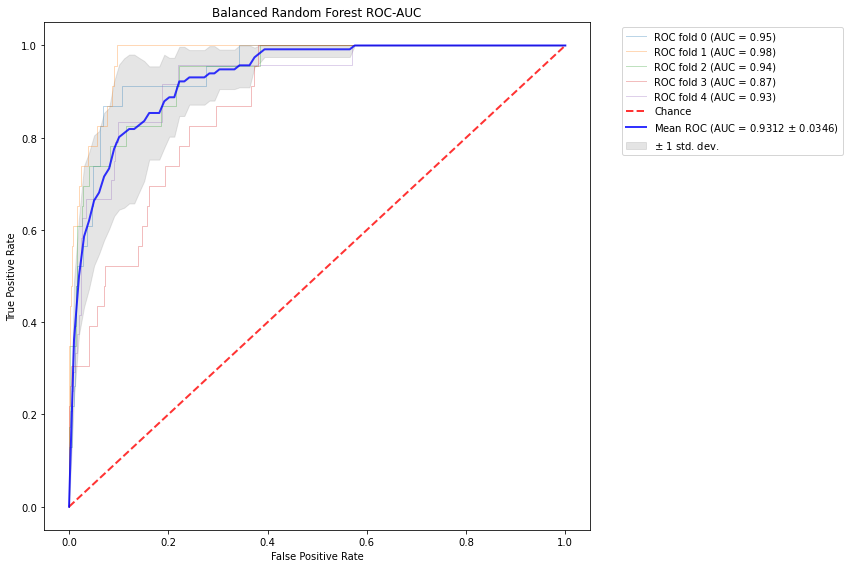

In [7]:
brf_res = roc_plt(X, y, pipe_BRF, "Balanced Random Forest ROC-AUC", seed=seed, create_plot=True)
save_pkl(brf_res, "brf_res_ROC_RFE", PICKLE_PATH)

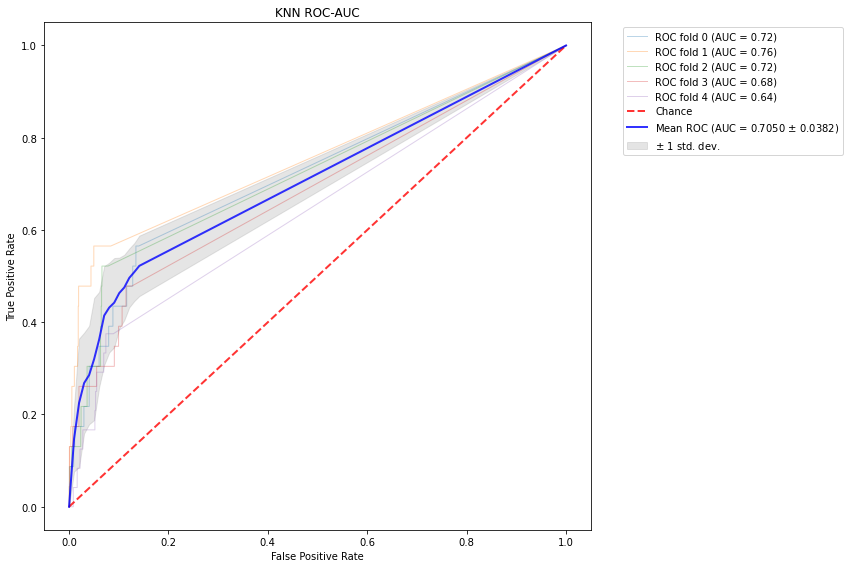

In [8]:
knn_res = roc_plt(X, y, pipe_KNN, "KNN ROC-AUC", seed=seed, create_plot=True)
save_pkl(knn_res, "knn_res_ROC_RFE", PICKLE_PATH)

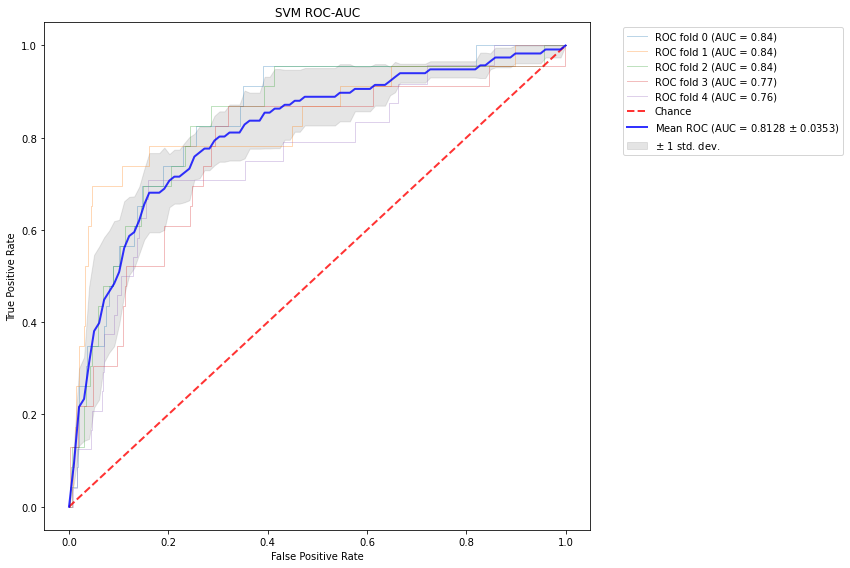

In [9]:
svm_res = roc_plt(X, y, pipe_SVM, "SVM ROC-AUC", seed=seed, create_plot=True)
save_pkl(svm_res, "svm_res_ROC_RFE", PICKLE_PATH)

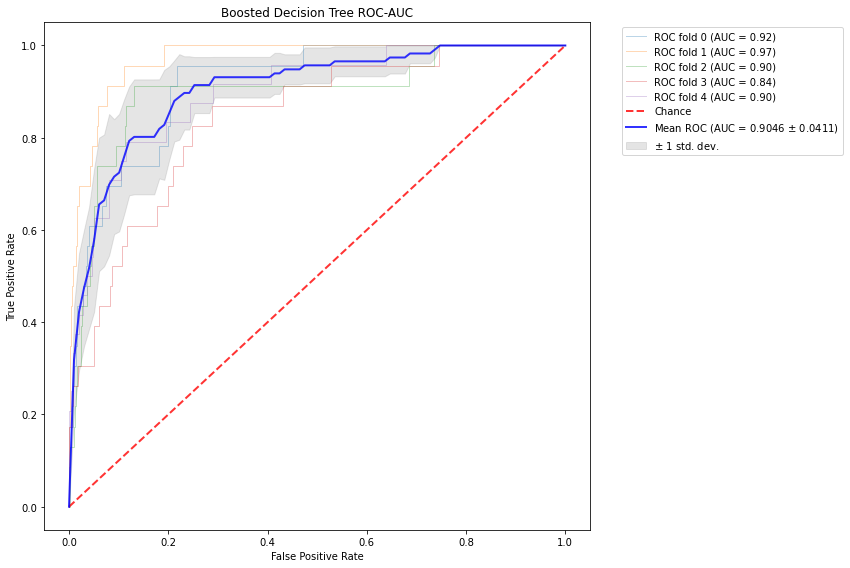

In [10]:
bdt_res = roc_plt(X, y, pipe_BDT, "Boosted Decision Tree ROC-AUC", seed=seed, create_plot=True)
save_pkl(bdt_res, "bdt_res_ROC_RFE", PICKLE_PATH)

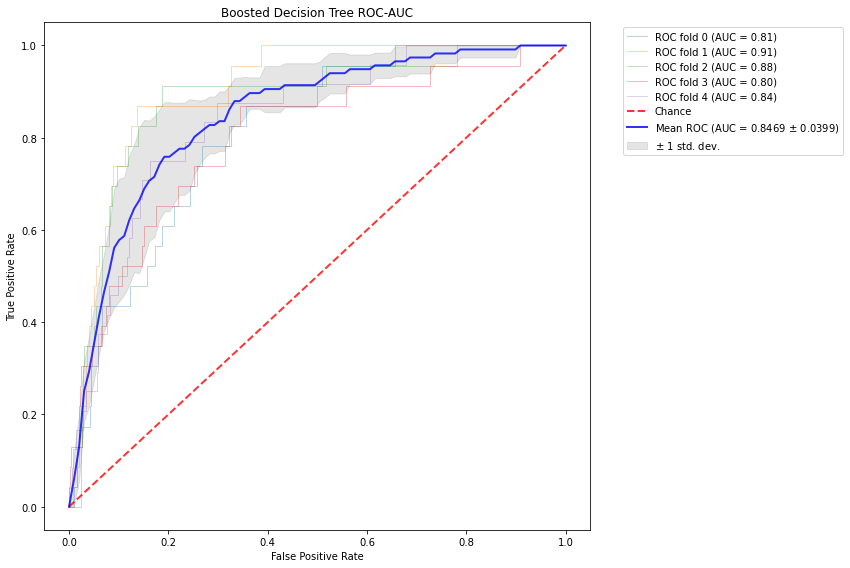

In [24]:
nn_res = roc_plt(X_tr_pd, y, pipe_NN, "Boosted Decision Tree ROC-AUC", seed=seed, create_plot=True)
save_pkl(nn_res, "nn_res_ROC_RFE", PICKLE_PATH)

### Final Plot

In [5]:
k_folds = 5

bdt_res = load_pkl("bdt_res_ROC_RFE", PICKLE_PATH)
bdt_res['clf'] = 'Boosted Decision Trees'
svm_res = load_pkl("svm_res_ROC_RFE", PICKLE_PATH)
svm_res['clf'] = 'Support Vector Machine'
brf_res = load_pkl("brf_res_ROC_RFE", PICKLE_PATH)
brf_res['clf'] = 'Balanced Random Forest'
knn_res = load_pkl("knn_res_ROC_RFE", PICKLE_PATH)
knn_res['clf'] = 'K-Nearest Neighbors'
nn_res = load_pkl("nn_res_ROC_RFE", PICKLE_PATH)
nn_res['clf'] = 'Neural Network'

rocauc_res = pd.concat([svm_res, bdt_res, knn_res, brf_res, nn_res])
rocauc_res['Classifier'] = rocauc_res['clf'] + ' : Auc Score: ' + rocauc_res['mean_auc'].round(4).astype(str)
rocauc_res = rocauc_res.sort_values('mean_auc', ascending=False)

model_names = ['Boosted Decision Trees','Support Vector Machine','Balanced Random Forest','K-Nearest Neighbors','Neural Network']
colors = dict(zip(model_names, sns.color_palette("colorblind",5))) 
colors = {k: colors[k] for k in rocauc_res['clf'].unique().tolist()}

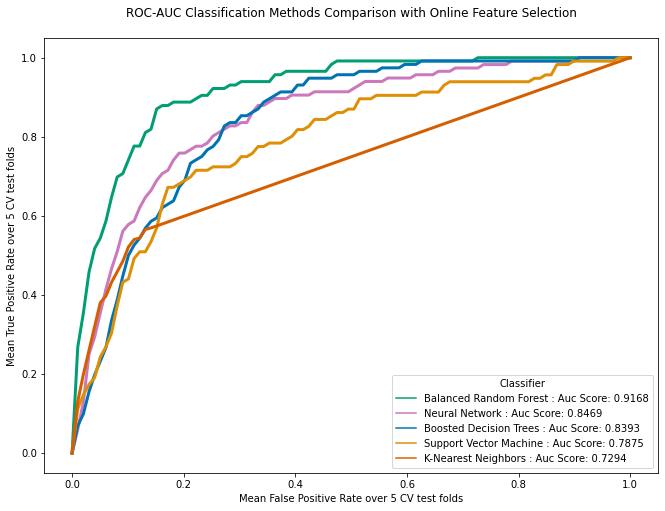

In [7]:
aggregated_roc_plot(rocauc_res, list(colors.values()), 'ROC-AUC Classification Methods Comparison with Online Feature Selection\n', IMG_PATH+'roc_on_fs.png')